In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score
from scipy.special import erf, erfc

import joblib

In [3]:
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Length of array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)        # Area normal dist.    
    return prob >= criterion      # Use boolean array outside this function

In [11]:
df = pd.read_csv('../../data/MWRA/MWRA.csv')

ph_var = 'pH ()' # ph out
TA_var = 'TA in (mmol/kgSW)'
sal_var = 'SAL (PSU)'
temp_var = 'TEMP (C)'
depth_var = 'DEPTH (m)'
station_var = 'STAT_ID'
aragonite_var = 'WAr out'
TCO2_var = 'TCO2 in (mmol/kgSW)'
ox_var = 'DISS_OXYGEN (mg/L)'
fluor_var = 'FLUORESCENCE (ug/L)'
date_var = 'PROF_DATE_TIME_LOCAL'

df.loc[df['VAL_QUAL'] == -1, ph_var] = np.NaN
# df = df[['VAL_QUAL'] == -1]


df = df[[station_var,'LATITUDE', 'LONGITUDE', depth_var, temp_var, sal_var, ox_var, fluor_var, TA_var, TCO2_var, ph_var, aragonite_var, date_var]]
df.columns = ['Station','Latitude','Longitude','Depth','Temperature','Salinity','Oxygen','Fluorescence', 'TA','TCO2','pH','Ar','Date']


df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = df['Date'].apply(lambda x: x.toordinal())

print(len(df))
df = df[df['Station'] != 'HAR']
df = df[df['Station'] != 'NFAL']
df = df[df['Station'] != 'POC']

TA_v = 'TA'
sal_v = 'Salinity'
station_v = 'Station'

df.head()

4476


,Station,Latitude,Longitude,Depth,Temperature,Salinity,Oxygen,Fluorescence,TA,TCO2,pH,Ar,Date,Time
0,F13,42.269424,-70.732788,1.61,3.386,32.52,10.43,2.137,NaN,NaN,8.040,NaN,2017-02-18 08:06:00,736378
1,F13,42.269356,-70.732902,5.63,3.425,32.52,10.42,9.371,NaN,NaN,8.027,NaN,2017-02-18 08:06:00,736378
2,F13,42.269283,-70.733040,11.00,3.592,32.55,10.36,6.480,NaN,NaN,8.001,NaN,2017-02-18 08:06:00,736378
3,F13,42.269234,-70.733170,16.75,3.690,32.57,10.33,4.057,NaN,NaN,7.973,NaN,2017-02-18 08:06:00,736378
4,F13,42.269157,-70.733391,22.79,3.794,32.59,10.31,3.527,NaN,NaN,7.922,NaN,2017-02-18 08:06:00,736378


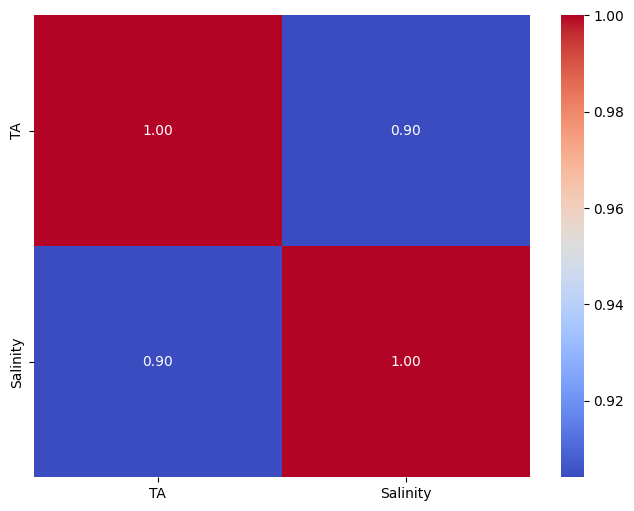

In [5]:
# Calculating correlation matrix
correlation_matrix = df[[TA_v, sal_v]].corr()

# Plotting correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [6]:
stations = ['F13', 'F06', 'F10', 'F15', 'N07', 'N18', 'N21', 'F22', 'N04', 'N01', 'F23', 'F17', 'N10', 'F05']

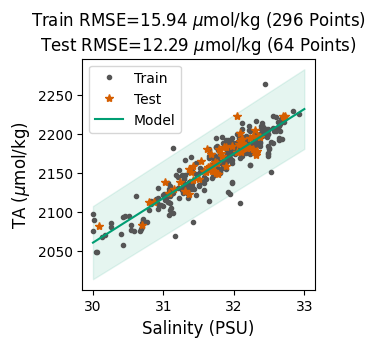

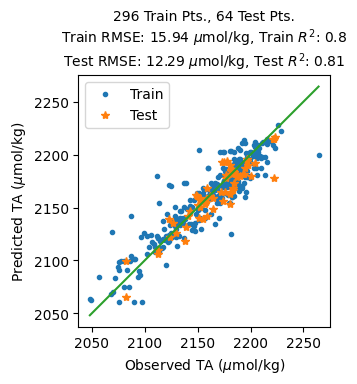

In [8]:
test_station = 'F06'

df_model = df.copy()

# df_model = df_model[df_model[station_v] != 'HAR']
# df_model = df_model[df_model[station_v] != 'NFAL']
# df_model = df_model[df_model[station_v] != 'POC']

df_model = df_model[df_model[station_v].isin(stations)]

df_model = df_model[~df_model[sal_v].isna()]
df_model = df_model[~df_model[TA_v].isna()]
df_model = df_model.loc[chauvenet(df_model[TA_v])]
df_model = df_model.loc[chauvenet(df_model[sal_v])]

df_train = df_model[df_model[station_v] != test_station]
df_test = df_model[df_model[station_v] == test_station]

X_train = np.atleast_2d(df_train[sal_v]).T
y_train = np.array(df_train[TA_v])

X_test = np.atleast_2d(df_test[sal_v]).T
y_test = np.array(df_test[TA_v])
X_test2 = np.atleast_2d(np.arange(30,34)).T
X_test3 = np.atleast_2d(df[~df[sal_v].isna()][sal_v]).T

model = BayesianRidge().fit(X_train, y_train)
joblib.dump(model, '../checkpoints/TA_regression/model.pkl')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred2, y_pred_std2 = model.predict(X_test2, return_std=True)
y_pred3, y_pred_std3 = model.predict(X_test3, return_std=True)

df.loc[~df[sal_v].isna(), 'TA (Prediction)'] = y_pred3
df.loc[~df[sal_v].isna(), 'TA (Std. Dev.)'] = y_pred_std3

train_rmse = np.sqrt(np.mean(np.square(y_train_pred.flatten()-y_train.flatten())))
train_r2 = r2_score(y_train_pred.flatten(), y_train.flatten())

test_rmse = np.sqrt(np.mean(np.square(y_test_pred.flatten()-y_test.flatten())))
test_r2 = r2_score(y_test_pred.flatten(), y_test.flatten())

ttl_coef = 'Coef: ' + str(np.round(model.coef_[0], 2)) + ' , Intercept: ' + str(np.round(model.intercept_, 2))
ttl_num_pts = str(len(y_train)) + ' Train Pts., ' + str(len(y_test)) + ' Test Pts.'
ttl_train = 'Train RMSE: ' + str(np.round(train_rmse, 2)) + ' $\mu$mol/kg, Train $R^2$: ' + str(np.round(train_r2, 2))
ttl_test = 'Test RMSE: ' +  str(np.round(test_rmse, 2)) + ' $\mu$mol/kg, Test $R^2$: ' + str(np.round(test_r2, 2))


ttl4 =  'Train RMSE=' + str(np.round(train_rmse, 2)) + ' $\mu$mol/kg (' + str(len(y_train)) + ' Points)'  
ttl5 =  'Test RMSE=' + str(np.round(test_rmse, 2))  + ' $\mu$mol/kg (' + str(len(y_test)) + ' Points)'  

fig=plt.figure(figsize=(3,3))
plt.plot(X_train, y_train, '.', color='#555555', label='Train')
plt.plot(X_test, y_test, '*', color = '#D55E00', label='Test')
plt.plot(X_test2, y_pred2, label='Model', color='#009E73')
plt.fill_between(X_test2.flatten(), y_pred2+y_pred_std2, y_pred2-y_pred_std2, color='#009E73', alpha=0.1)
plt.xlabel('Salinity (PSU)', fontsize=12)
plt.ylabel('TA ($\mu$mol/kg)', fontsize=12)
plt.title(ttl4 + '\n' + ttl5)
plt.legend();
# fig.savefig('../Figures/TA_model.png', dpi=1000, bbox_inches='tight')
# fig.savefig('../Figures_PDF/TA_model.pdf', dpi=300, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(3.5,4))
ax.plot(y_train, y_train_pred,'.', label='Train')
ax.plot(y_test, y_test_pred, '*', label='Test')
ax.plot(np.linspace(y_train.min(), y_train.max()), np.linspace(y_train.min(), y_train.max()))
plt.xlabel('Observed TA ($\mu$mol/kg)')
plt.ylabel('Predicted TA ($\mu$mol/kg)')
plt.title(ttl_num_pts + '\n' + ttl_train + '\n' + ttl_test, fontsize=10)
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
# fig.savefig('../Figures/TA_R2.png', dpi=1000, bbox_inches='tight')
# fig.savefig('../Figures/TA_R2.pdf', dpi=300, bbox_inches='tight')


In [10]:
X_train.shape

(296, 1)